# Notebook for working and building models for the MFCC features
### In this notebook, we did the following



#### 1) Extracted MFCC features from the audio samples in the crowd sourced english accent dataset which has already been prepared in the preprocessing notebe

#### 2) We labeled the MFCC features

#### 3) we split the exctracted MFCC features into train and validate data

### 4) We trained and evaluated the MFCCs with a CNN, LSTM and MLP model

+ Additionally, because the proposed best performing model was built in this notebook, we finetuned the CNN on the LibriTTs dataset to check for generalization and explore transfer learning capabilities of the model



#### Mounting the colab notebook to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Saving the path to the accent detection project as a variable

In [ ]:
drive_path = "/content/drive/MyDrive/Accent Detection"

In [ ]:
!pip install pydub

#### Importing the necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import os
import pydub
import pickle
import soundfile as sf
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense

### The "Save to pickle" and "read_from_pickle" functions.
+ The pickle library is used to save variables as objects which can be loaded back into a session.
+ The functions where created to aid saving variables and models as pickle objects, so that they could be easily loaded up later rather than running all the code from the top again which is timely expensive

In [ ]:
def save_to_pickle(path, name, variable):
  outfile = open(f"{path}/{name}.pkl", "wb")
  pickle.dump(variable, outfile)
  outfile.close()

In [ ]:
def read_pickle(path, name):
  infile = open(f"{path}/{name}", "rb")
  pickle_object = pickle.load(infile)
  infile.close()

  return pickle_object

## Visualizations
+ We first start by visualizing the waveforms and the mfcc features that was used for training the models

#### loading up the waveform and the sample rate of a random audio file

In [ ]:
sample_audio_path = f"{drive_path}/Data/train/southern/sof_00295_00015624900.wav"
sample_wav, sample_sr = librosa.load(sample_audio_path)

### Visualizing the wave form with normalization, without normalization and a combination of both

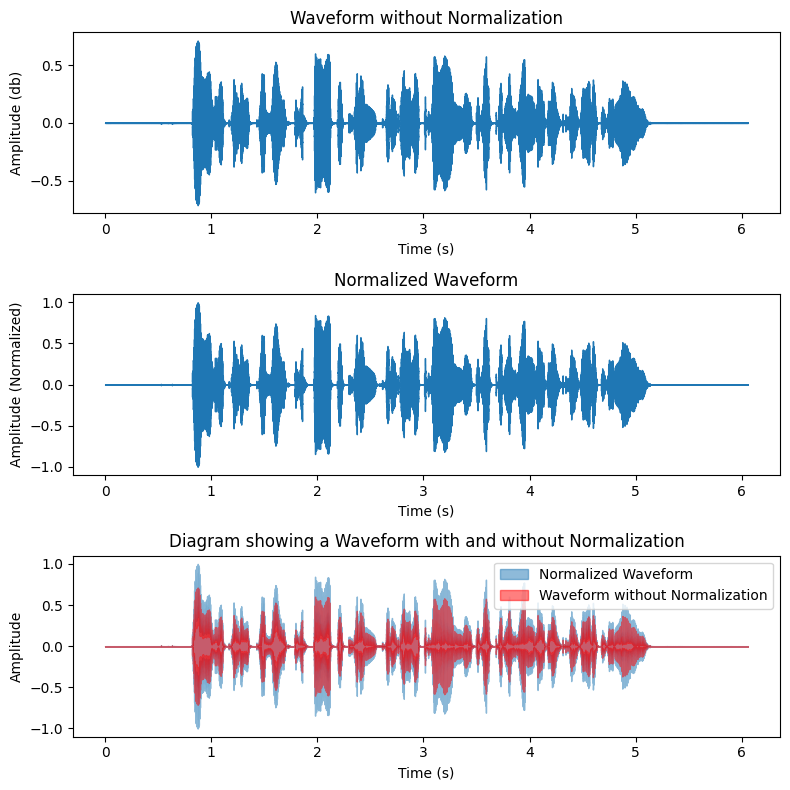

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the waveform without normalization
plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
librosa.display.waveshow(sample_wav, sr = sample_sr)
plt.title('Waveform without Normalization')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (db)')

# Plot the normalized waveform
sample_wav_normalized = librosa.util.normalize(sample_wav)

plt.subplot(3, 1, 2)
librosa.display.waveshow(sample_wav_normalized, sr=sample_sr)
plt.title('Normalized Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Normalized)')

# Plot the combined waveform
plt.subplot(3, 1, 3)
librosa.display.waveshow(sample_wav_normalized, sr=sample_sr, alpha=0.5, label='Normalized Waveform')  # Waveform without normalization in blue
librosa.display.waveshow(sample_wav, sr=sample_sr, color='red', alpha=0.5, label='Waveform without Normalization' )  # Normalized waveform in red
plt.title('Diagram showing a Waveform with and without Normalization')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

#### Visualizing the Mel-Frequency Ceptral Coefficients (MFCCs)

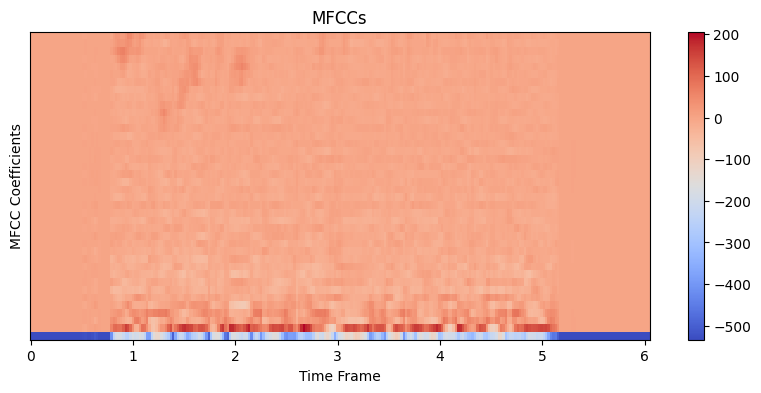

In [ ]:
mfccs = librosa.feature.mfcc(y=sample_wav, sr=sample_sr, n_mfcc=40)

# Display MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time',)
plt.colorbar()
plt.title('MFCCs')
plt.xlabel('Time Frame')
plt.ylabel('MFCC Coefficients')
plt.show()

### The "extract_mfcc_features" class
#### This class is designed to carry out extract mfcc features from audio files

#### About the "extract_mfcc_features" class
(1) The class is not instantiated with any parameter but has 3 methods<br />
(2) The methods of the class include the extract_from_single_audio, the extract_from_files_in_directory and the extract_for_multiple_classes methods.<br />
(3) The methods of the class all have similar default parameters which can be changed if needed. The default parameters common among all the methods are the sr which specifies the desired sample rate, n_fft which specifies the number of samples to be used for the short-time Fourier transform, n_mfcc which specifies the desired number of mfcc coefficients, hop_length which specifies the number of samples between frames, and normalize which specifies if the audio should be normalized or not

#### About the  "extract_mfcc_features" class methods
<h4 style="text-decoration: underline;">(1) extract_from_single_audio</h4>
<p> The extract_from_single_audio method simply extracts and returns the mfcc features for a single audio file specified with the path parameter</p>

<h4 style="text-decoration: underline;">(2) extract_from_files_in_directory</h4>
<p> The pitch extract_from_files_in_directory extracts mfcc features from all the audio files in a directory (for a single class), specified by the path parameter</p>
<p>The method returns a dictonary of the class names (which would all be the same because it extracts for a single class) and the mfcc features</p>

<h4 style="text-decoration: underline;">(3) extract_for_multiple_classes</h4>
<p> This method extracts mfcc features from audio files for different classes all in a directory specidied by the path parameter</p>
<p>The method takes in a default parameter in addition to the path path parameter and the common parameters accross all the methods. This additonal parameter "df" expects a boolean which determines if a dataframe or a dictionary of the mfcc features should be returned</p>

In [ ]:
class extract_mfcc_features():
    def __init__(self):
        pass

    def extract_from_single_audio(self, path, sr = 22050, n_fft = 2048, n_mfcc = 40, hop_length = 512, normalize = True):
        # (1) Loading the signal and the sample rate for the audio file in the specified path
        signal, sr = librosa.load(path, mono = True, sr = sr)

        # (2) Normalizing the audio data if the normalize parameter is set to true
        if normalize:
            signal = librosa.util.normalize(signal)

        # (3) Extracting the mfcc features using the specified parameters
        mfccs = librosa.feature.mfcc(y = signal, sr = sr, n_fft = n_fft, n_mfcc = n_mfcc, hop_length = hop_length)

        # (4) Getting the duration
        duration = librosa.get_duration(y = signal, sr = sr)

        # (5) Returning the transpose of the mfcc features and the durations
        return (mfccs.T, duration)



    def extract_from_files_in_directory(self, path, sr = 22050, n_fft = 2048, n_mfcc = 40, hop_length = 512, normalize = True):
        # (1) The name of the class is the directory name and so it is extracted using the split method
        class_name = path.split("/")[-1]

        # (2) Creating a list to hold the the name of the class for each iteration for the purpose of labelling
        class_list = []

        # (3) Creating a list to hold the mfcc features for the audio files in the class
        mfcc_list = []
        durations_list = []

        # (4) storing a list of the the audio file names at the directory in the specified path
        audio_files = os.listdir(path)

        print(f"Extracting mfcc features for {class_name} class")
        # (5) Iterating over the audiofiles in the directory
        for audio_file in tqdm(audio_files):

            # (6) Appending the name of the class to the class_list
            class_list.append(class_name)

            # (7) Appending the the mfcc features for each of the files to the list of the mfcc features for the class
            mfcc_and_durations = self.extract_from_single_audio(f"{path}/{audio_file}",
                                                             sr = sr,
                                                             n_fft = n_fft,
                                                             n_mfcc = n_mfcc,
                                                             hop_length = hop_length,
                                                             normalize = normalize)
            mfcc_list.append(mfcc_and_durations[0])

            # (8) Appending the duratations of the files to a list
            durations_list.append(mfcc_and_durations[1])

        # (9) Creating a dictionary to hold the class_name and the mfccs of its audio files
        class_dict = {"class names": class_list, "mfccs": mfcc_list, "duration": durations_list}

        # (10) Returning the dictionary of the class and its mfcc features
        return class_dict



    def extract_for_multiple_classes(self, path, sr = 22050, n_fft=2048, n_mfcc=40, hop_length = 512, normalize=True, df=True):
        # (1) Storing a list of all the class names in the specified path
        class_names = os.listdir(path)

        # (2) Creating a list that would hold the different class names
        class_list = []

        # (3) Creating a list that would hold the different mfcc features
        mfcc_list = []
        durations_list = []


        # (4) Iterating over the different class names
        for class_name in class_names:

            # (5) Calling the "extract_from_files_in_directory" method to extract the features from the different directories
            current_class = self.extract_from_files_in_directory(f"{path}/{class_name}",
                                                                 sr = sr,
                                                                 n_fft = n_fft,
                                                                 n_mfcc = n_mfcc,
                                                                 hop_length = hop_length,
                                                                 normalize = normalize)

            # (6) Joining the new class names gotten from the call above to the old ones
            class_list = class_list + current_class["class names"]

            # (7) Joining the new mfcc features gotten from the call above to the old ones
            mfcc_list = mfcc_list + current_class["mfccs"]

            # (8) Joining the new audio durations gotten from the call above to the old ones
            durations_list = durations_list + current_class["duration"]

        # (8) Creating a dictionary to store the class names and thier mfcc features
        classes_dict = {"class names": class_list, "mfccs": mfcc_list, "duration": durations_list}

        # (9) Returning a dataframe of the class names and thier mffcc features if the df parameter is set to True
        if df:
            return pd.DataFrame(classes_dict)
        # (10) Returning the classes_dict dictionary if the df parameter is set to False
        else:
            return classes_dict

## Testing the "extract_mfcc_features" class

#### creating an instance of the class for testing purposes

In [ ]:
test = extract_mfcc_features()

#### Creating different paths to test the different methods of the class

In [ ]:
single_audio_test_path = f"{drive_path}/feature_extraction_test/train/irish/irm_02484_00032769822.wav"
single_class_test_path = f"{drive_path}/feature_extraction_test/train/irish"
multiple_class_test_path = f"{drive_path}/feature_extraction_test/train"

#### Testing the "extract_from_single_audio" method

In [ ]:
test.extract_from_single_audio(single_audio_test_path)

(array([[-5.5334137e+02,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-5.5264435e+02,  9.8144186e-01,  9.6867955e-01, ...,
         -3.6666486e-01, -3.3895314e-01, -3.0891931e-01],
        [-5.5201318e+02,  1.7866204e+00,  1.5915910e+00, ...,
         -5.8170289e-01, -6.6646987e-01, -6.9518071e-01],
        ...,
        [-5.4997357e+02,  4.6670599e+00,  4.3874407e+00, ...,
          5.7676154e-01,  8.9001858e-01,  1.1318383e+00],
        [-5.4751874e+02,  7.9418116e+00,  7.1307936e+00, ...,
          1.3348632e+00,  1.0928870e+00,  7.0276588e-01],
        [-5.4887976e+02,  6.0755453e+00,  5.4447737e+00, ...,
          2.0597377e+00,  1.4046892e+00,  6.5348840e-01]], dtype=float32),
 9.898684807256236)

#### Testing the "extract_from_files_in_directory" method

In [ ]:
test.extract_from_files_in_directory(single_class_test_path)

Extracting mfcc features for irish class


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


{'class names': ['irish', 'irish', 'irish', 'irish', 'irish'],
 'mfccs': [array([[-5.5076703e+02,  5.1718473e-02,  5.1427253e-02, ...,
          -3.3360969e-02, -3.5729673e-02, -3.7963413e-02],
         [-5.5037195e+02,  5.9843493e-01,  5.6271112e-01, ...,
          -1.5404397e-01, -1.7071342e-01, -1.8690524e-01],
         [-5.4749786e+02,  4.5245209e+00,  4.0879030e+00, ...,
          -1.8533722e+00, -2.0096643e+00, -2.0677316e+00],
         ...,
         [-4.7773196e+02,  4.5738934e+01, -3.9073593e+01, ...,
          -3.5658221e+00, -6.8146217e-01,  2.3169413e+00],
         [-3.8280215e+02,  8.6815369e+01, -6.7561905e+01, ...,
           7.5299335e-01,  1.0834832e+00,  2.9635689e-01],
         [-3.7863428e+02,  9.6923149e+01, -5.2708359e+01, ...,
          -8.0204231e-01, -1.0246271e-01, -2.4838279e-01]], dtype=float32),
  array([[-5.2654663e+02,  3.0118647e+00,  2.8848886e+00, ...,
           2.9057360e-01,  1.4672369e-01, -9.1007948e-03],
         [-5.2438037e+02,  6.0334220e+00,  

#### Testing the "extract_for_multiple_classes" method

In [ ]:
extract_for_multiple_classes_test_df = test.extract_for_multiple_classes(multiple_class_test_path, df=True)

Extracting mfcc features for northern class


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


Extracting mfcc features for southern class


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


Extracting mfcc features for scottish class


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Extracting mfcc features for welsh class


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]


Extracting mfcc features for midlands class


100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Extracting mfcc features for irish class


100%|██████████| 5/5 [00:00<00:00, 29.14it/s]


#### Visualizing the dataframe of the extracted test MFCC features, thier class names and thier durations.
+ We did not really delve into the durations because they dont matter based on the techniques we used but they are nice to haves
+ It is also worth to mention that duration for the dataframe below is measured in seconds

In [ ]:
extract_for_multiple_classes_test_df

,class names,mfccs,duration
0,northern,"[[-566.6713, 0.09986578, 0.08564799, 0.0634317...",5.034694
1,northern,"[[-492.66565, 21.552872, -28.028744, -12.9114,...",5.717370
2,northern,"[[-505.69217, 33.347504, 17.86431, 8.611246, 8...",4.949342
3,northern,"[[-542.3909, 11.377636, 7.757784, 4.0659294, 1...",5.546667
4,northern,"[[-535.6606, 3.6212788, 3.1746473, 2.5689259, ...",3.072018
5,northern,"[[-596.366, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4.437370
6,northern,"[[-572.2936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",4.949342
7,northern,"[[-540.05774, 0.18707371, 0.18500262, 0.181565...",4.693333
8,northern,"[[-446.87863, 11.079239, -45.878914, 17.583405...",7.680000
9,southern,"[[-527.8853, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",9.984036


#### The test has been complete and we can now proceede to apply the method for mfcc extraction of the uk accident dataset

## Now we extract the mfcc features for the UK accent dataset

#### Creating an instance of the "extract_mfcc_features" class for the purpose of extracting mfcc features of the UK accent data

In [ ]:
extract_uk_accent_mfccs = extract_mfcc_features()

#### Creating the paths to where mfccs should be extracted from for the train, augmented, and test

In [ ]:
train_data_path = f"{drive_path}/Data/train"
test_data_path = f"{drive_path}/Data/test"
augmented_train_data_path = f"{drive_path}/Data/augmented_train"

#### Using the "extract_for_multiple_classes" method to extract the mfcc features for the train, augmented, and test data

##### Extracting for the train data

In [ ]:
train_df = extract_uk_accent_mfccs.extract_for_multiple_classes(train_data_path)

Extracting mfcc features for southern class


100%|██████████| 6794/6794 [08:18<00:00, 13.63it/s]


Extracting mfcc features for welsh class


100%|██████████| 2280/2280 [03:08<00:00, 12.11it/s]


Extracting mfcc features for scottish class


100%|██████████| 2035/2035 [02:21<00:00, 14.41it/s]


Extracting mfcc features for midlands class


100%|██████████| 557/557 [00:39<00:00, 14.16it/s]


Extracting mfcc features for northern class


100%|██████████| 2278/2278 [03:06<00:00, 12.22it/s]


Extracting mfcc features for irish class


100%|██████████| 360/360 [00:32<00:00, 10.98it/s]


##### Extracting for the test data

In [ ]:
test_df = extract_uk_accent_mfccs.extract_for_multiple_classes(test_data_path)

Extracting mfcc features for southern class


100%|██████████| 1698/1698 [01:31<00:00, 18.46it/s]


Extracting mfcc features for welsh class


100%|██████████| 569/569 [00:30<00:00, 18.75it/s]


Extracting mfcc features for northern class


100%|██████████| 569/569 [00:30<00:00, 18.64it/s]


Extracting mfcc features for scottish class


100%|██████████| 508/508 [00:34<00:00, 14.59it/s]


Extracting mfcc features for midlands class


100%|██████████| 139/139 [00:34<00:00,  4.07it/s]


Extracting mfcc features for irish class


100%|██████████| 90/90 [01:21<00:00,  1.11it/s]


##### Extracting for the augmented data (This would later be mixed with the train data)

In [ ]:
augmented_train_df = extract_uk_accent_mfccs.extract_for_multiple_classes(augmented_train_data_path)

Extracting mfcc features for southern class


100%|██████████| 6794/6794 [06:20<00:00, 17.87it/s]


Extracting mfcc features for northern class


100%|██████████| 2278/2278 [02:18<00:00, 16.40it/s]


Extracting mfcc features for irish class


100%|██████████| 360/360 [00:19<00:00, 18.02it/s]


Extracting mfcc features for welsh class


100%|██████████| 2280/2280 [02:28<00:00, 15.36it/s]


Extracting mfcc features for midlands class


100%|██████████| 557/557 [00:28<00:00, 19.86it/s]


Extracting mfcc features for scottish class


100%|██████████| 2035/2035 [01:43<00:00, 19.69it/s]


## Now that the features are extracted, we proceed to store all the dataframes for the features as objects using the pickle module.

#### Specifying the path where the extracted mfcc dataframes would reside

In [ ]:
pickle_mfcc_dfs_path = f"{drive_path}/Pickle Objects/mfcc dataframes"

#### Saving the train_df

In [ ]:
save_to_pickle(pickle_mfcc_dfs_path, "train_df", train_df)

#### Saving the test_df

In [ ]:
save_to_pickle(pickle_mfcc_dfs_path, "test_df", test_df)

#### Saving the augmented_train_df

In [ ]:
save_to_pickle(pickle_mfcc_dfs_path, "augmented_train_df", augmented_train_df)

#Preparing the Extracted MFCC Features for Deep Learning

### In this section, we prepared the dataset for deep learning using the following steps.
+ First we labeled the data using the table in below this cell
+ Secondly, we split the data into train(and validate), and test
+ Thirdly, we padded the data mfcc lengths that were not up to the maximum length

In [ ]:
pd.DataFrame({
    "Accent": ["Irish", "Midlands", "Northern", "Scottish", "Southern", "Welsh"],
    "Label": [0,1,2,3,4,5]
    })

,Accent,Label
0,Irish,0
1,Midlands,1
2,Northern,2
3,Scottish,3
4,Southern,4
5,Welsh,5


+ Table showing the Accents and thier labels

<br />

#### First we define the path to the MFCC dataframes

In [ ]:
pickle_mfcc_dfs_path = f"{drive_path}/Pickle Objects/mfcc dataframes"


#### Calling the read pickle function to read in the dataframes into variables

In [ ]:
augmented_train_df = read_pickle(pickle_mfcc_dfs_path,"augmented_train_df.pkl")
train_df = read_pickle(pickle_mfcc_dfs_path,"train_df.pkl")
test_df = read_pickle(pickle_mfcc_dfs_path,"test_df.pkl")

#### Combining the train dataframe and the augmented dataframe to form the train data

In [ ]:
train_data = pd.concat([train_df, augmented_train_df], axis=0, ignore_index=True)
train_data

,class names,mfccs,duration
0,northern,"[[-520.1455, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1.621361
1,southern,"[[-576.06213, 1.7840254, 1.609385, 1.3430701, ...",1.621361
2,southern,"[[-542.98566, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",1.621361
3,scottish,"[[-563.8456, 0.5002478, 0.47173178, 0.4254218,...",1.706667
4,northern,"[[-538.26764, 12.27438, 10.001707, 8.13177, 5....",1.706667
...,...,...,...
28603,welsh,"[[-527.2304, 0.7316793, 0.48441106, 0.13281903...",17.066667
28604,welsh,"[[-453.96417, 58.064064, -12.116699, -20.83833...",17.578685
28605,welsh,"[[-545.0288, 6.001998, 5.504197, 4.7543936, 3....",17.834694
28606,welsh,"[[-506.7468, 41.151756, 29.415962, 15.635234, ...",18.432018


#### We then created a function to assist us in labelling the dataset

In [ ]:
# A function is first defined to label the accents correctly
def label_accents(accent):
  label = None
  if accent == "irish":
    label = 0
  elif accent == "midlands":
    label = 1
  elif accent == "northern":
    label = 2
  elif accent == "scottish":
    label = 3
  elif accent == "southern":
    label = 4
  elif accent == "welsh":
    label = 5

  return label

#### Applying the "label_accents" function to label the class names in the train data and visualizing the first 5 rows

In [ ]:
train_data["labels"] = train_data["class names"].apply(label_accents)
train_data

train_df["labels"] = train_df["class names"].apply(label_accents)
train_df

augmented_train_df["labels"] = augmented_train_df["class names"].apply(label_accents)
augmented_train_df

,class names,mfccs,duration,labels
0,southern,"[[-286.09207, 114.200745, 17.78207, 25.95323, ...",1.621361,4
1,northern,"[[-285.57428, 142.70703, -23.158623, 11.127176...",1.621361,2
2,southern,"[[-329.38516, 114.91384, -37.87437, 6.7240963,...",1.621361,4
3,northern,"[[-312.82974, 119.51415, -8.753107, 20.108902,...",1.706667,2
4,scottish,"[[-299.02426, 161.3929, -18.568363, 13.45236, ...",1.706667,3
...,...,...,...,...
14299,welsh,"[[-527.2304, 0.7316793, 0.48441106, 0.13281903...",17.066667,5
14300,welsh,"[[-453.96417, 58.064064, -12.116699, -20.83833...",17.578685,5
14301,welsh,"[[-545.0288, 6.001998, 5.504197, 4.7543936, 3....",17.834694,5
14302,welsh,"[[-506.7468, 41.151756, 29.415962, 15.635234, ...",18.432018,5


#### Applying the "label_accents" function to label the class names in the test data and visualizing the first 5 rows

In [ ]:
# The function is then applied to the accent column to create a new colums for the labeled accents
test_df["labels"] = test_df["class names"].apply(label_accents)
test_df

,class names,mfccs,duration,labels
0,southern,"[[-572.7521, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",7.509342,4
1,southern,"[[-554.7232, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",5.546667,4
2,southern,"[[-542.5773, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",3.498685,4
3,southern,"[[-511.75095, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",4.778685,4
4,southern,"[[-488.21915, 6.8805656, -6.2837496, -7.521497...",9.728027,4
...,...,...,...,...
3568,irish,"[[-588.97577, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",3.754694,0
3569,irish,"[[-588.76373, 0.65316635, 0.6524987, 0.6513907...",6.485351,0
3570,irish,"[[-643.35864, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",4.522676,0
3571,irish,"[[-609.74646, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",6.229342,0


#### Defining variables to hold the features and the labels for the train and the test data

In [ ]:
X_w_aug = augmented_train_df["mfccs"]
y_w_aug = np.array(augmented_train_df["labels"])

X = train_df["mfccs"]
y = np.array(train_df["labels"])

X_test = test_df["mfccs"]
y_test = np.array(test_df["labels"])

#### Splitting the train data into train and validation with the 80 percent for training and 20 percent for validation

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)
X_train_with_aug, X_val_with_aug, y_train_with_aug, y_val_with_aug = train_test_split(X_w_aug, y_w_aug, test_size = 0.2, stratify = y_w_aug, random_state = 42)

#### Checking the maximum sequence length of the mfcc features.
+ This is important because the the sequence lengths are not equal across the features and the deep learning models that are beign used expect a fixed length (Although padded values would be masked out during training for some models)

In [ ]:
max_mfcc_len = 0

for feature in X_train:
  max_mfcc_len = max(max_mfcc_len, len(feature))

max_mfcc_len

868

#### Using the maximum length to pad the sequence lengths that are not up to the maximum with 0 for the x_train, x_val and x_test

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_mfcc_len, padding='post', truncating='post', dtype='float32')
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_mfcc_len, padding='post', truncating='post', dtype='float32')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_mfcc_len, padding='post', truncating='post', dtype='float32')
X_train_with_aug = tf.keras.preprocessing.sequence.pad_sequences(X_train_with_aug, maxlen=max_mfcc_len, padding='post', truncating='post', dtype='float32')
X_val_with_aug = tf.keras.preprocessing.sequence.pad_sequences(X_val_with_aug, maxlen=max_mfcc_len, padding='post', truncating='post', dtype='float32')

#### Printing the new shapes of the x_train, x_val and x_test

In [ ]:
print(f"X_train_shape:{X_train.shape}")
print(f"X_val_shape:{X_val.shape}")
print(f"X_test_shape:{X_test.shape}")

X_train_shape:(11443, 868, 40)
X_val_shape:(2861, 868, 40)
X_test_shape:(3573, 868, 40)


#### Defining the path where the prepared data would be stored

In [ ]:
pickle_prepared_data_path  = f"{drive_path}/Pickle Objects/prepared data"

#### Calling the "Calling the save to pickle function to store the prepared data"

In [ ]:
save_to_pickle(pickle_prepared_data_path, "prepared_data", {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)})
save_to_pickle(pickle_prepared_data_path, "prepared_data_with_aug", {"train_with_aug": (X_train_with_aug, y_train_with_aug), "val_with_aug": (X_val_with_aug, y_val_with_aug)})

<br />

# Model Building

## In this section, we did the following;
+ Built a Convolutional Neural Network (CNN), a Recurrent Neural Network (RNN) and a Multilayer Perceptron (MLP) on the MFCC features that have been extraced and prepared in the sections above.
+ Evaluated each model using a confusion matrix and a classification report containing F1-scores, Recalls, Precisions and Accuracies

<Br />

### Before we started building each of the models, we defined a few functions and variables to avoid repeating code and they are as follows:

#### (1) We started by reading in the data that we have prepared with the help of the read_pickle function that we defined

In [ ]:
pickle_prepared_data_path = f"{drive_path}/Pickle Objects/prepared data"
prepared_data = read_pickle(pickle_prepared_data_path, "prepared_data.pkl")
prepared_aug_data = read_pickle(pickle_prepared_data_path, "prepared_data_with_aug.pkl")

#### (2) We then assigned the train, validation and test data to thier respective variable names

In [ ]:
X_train = prepared_aug_data["train_with_aug"][0]
X_val = prepared_data["val"][0]
X_test = prepared_data["test"][0]

y_train = prepared_aug_data["train_with_aug"][1]
y_val = prepared_data["val"][1]
y_test = prepared_data["test"][1]

#### (3) Due to the issue with imbalance in the dataset, we decided to generate and assign class weights for each accent class to prevent bias during the training phase

In [ ]:
# Getting the class weights for each of the classes in the dataset
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 6.622106481481482,
 1: 4.276158445440957,
 2: 1.046743505305525,
 3: 1.1714782964782964,
 4: 0.35090463048144743,
 5: 1.045595760233918}

#### (4) We then define a function that would have the responsibility of plotting the histories of the training and validation losses and accuracies for the models that we build to help us check our model for faults like overfitting

In [ ]:
# Model for plotting history for the training and validation accuracies and losses
def plot_history(history):
  # Plot training loss against validation loss

  #Plots the training loss as a line with label "Training loss"
  plt.plot(history.history["accuracy"], label="Training Accuracy")

  #Plots the validation loss as a line with label "validation loss"
  plt.plot(history.history["val_accuracy"], label="validation accuracy")

  #Sets the title of the plot to "Training and Validation loss"
  plt.title("Training and Validation accuracy")

  #Sets the label of the x-axis to "Epochs"
  plt.xlabel("Epochs")

  #Sets the label of the y-axis to "loss"
  plt.ylabel("Accuracy")

  #Shows the legend of the plot with the labels of the two lines.
  plt.legend()

  #Show the plot on the screen
  plt.show()



  # Plot training loss against validation loss

  #Plots the training loss as a line with label "Training loss"
  plt.plot(history.history["loss"], label="Training loss")

  #Plots the validation loss as a line with label "validation loss"
  plt.plot(history.history["val_loss"], label="validation loss")

  #Sets the title of the plot to "Training and Validation loss"
  plt.title("Training and Validation loss")

  #Sets the label of the x-axis to "Epochs"
  plt.xlabel("Epochs")

  #Sets the label of the y-axis to "loss"
  plt.ylabel("Loss")

  #Shows the legend of the plot with the labels of the two lines.
  plt.legend()

  #Show the plot on the screen
  plt.show()


#### (5) Defining a function to display the classification report and confusion matrix for a specified model on the mfcc features

In [ ]:
def display_classification_report_and_confusion_matrix(y_test, y_pred, model_name, features, class_names = ["irish", "midlands", "northern", "scottish", "southern", "welsh"]):
  # Printing the classification report
  print(classification_report(y_test, y_pred, digits=4))

  # Plotting the confusion matrix
  plt.figure(dpi=200, figsize=(15,20))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = class_names)
  plt.xticks(rotation=45)
  plt.title(f"Confusion Matrix for {model_name} model predictions{features}")
  plt.show()

#### (6) Defining a function to make a single MFCC prediction for a specified model

In [ ]:
def MFCC_model_single_prediction(path, model, model_type, class_names = ["irish", "midlands", "northern", "scottish", "southern", "welsh"]):
  # (1) First an instance of the extract_mfcc_features class we defined at the begining is created
  extract_mfcc = extract_mfcc_features()

  # (2) Using the extract_from_single_audio method of our class, we extract MFCC features for our specified audio
  mfcc = extract_mfcc.extract_from_single_audio(path)[0]

  # (3) We pad the MFCC features to all be with the same max length that we defined for our training set
  mfcc = tf.keras.preprocessing.sequence.pad_sequences([mfcc], maxlen=868, padding='post', truncating='post', dtype='float32')

  if model_type == "CNN":
    # Reshaping the MFCCs to be 3 dimensional if the model type is CNN
    mfcc = mfcc.reshape(mfcc.shape[0], mfcc.shape[1], mfcc.shape[2], 1)

  # (4) Using our model, we make a prediction for the MFCC we extracted from the audio we want to predict
  prediction = model.predict(mfcc)

  # (5) We then get the single prediction for the class that the (model thinks the) audio belongs to.
  single_prediction = class_names[np.argmax(prediction, axis = -1)[0]]

  # (6) We also want to get the confidence interval so we know how confident our model is when making a prediction
  confidence_levels = [(round(value * 100, 2)) for value in prediction[0]]

  # (7) We then convert the confidence intervals into a pandas dataframe for visualization purposes
  confidence_df =  pd.DataFrame({"class": class_names, "Confidence level": confidence_levels})

  # (8) We also want to be able to hear the audio so we can compare with what the model predicts
  play_audio = pydub.AudioSegment.from_mp3(path)

  # (9) return a dictionaty of the single prediction, the confidence intervals dataframe and the play_audio object
  return {"Prediction": single_prediction, "confidence_levels": confidence_df, "play_audio": play_audio}

### CNN model

#### For the CNN model we reshaped the data to be 3-dimensional because CNNs generally expect data to be 3-dimensional (like images)

In [ ]:
X_train_CNN = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val_CNN = X_val.reshape(X_val.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_CNN = X_test.reshape(X_test.shape[0], X_train.shape[1], X_train.shape[2], 1)

#### Building the architecture for the CNN Model

+ We experimented with different architectures and the one below proved to be the most effective. See the report for the most notable architectures that were used

In [ ]:
tf.keras.backend.clear_session()
CNN_model = Sequential([
    layers.Conv2D(32, 3, input_shape=(X_train.shape[1], X_train.shape[2], 1), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation = "softmax")
    ])
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 868, 40, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 434, 20, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 434, 20, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 217, 10, 64)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 217, 10, 64)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 217, 10, 128)      7

#### Compiling the CNN model

+ For compiling the CNN model, we experimented with different learninf rates and optimizers including Stochastic gradient descent (SGD), but a learning rate of 0.0005 with the Adaptove Moment Estimation (ADAM) proved to give the best results

In [ ]:
CNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss = "categorical_crossentropy",
              metrics=["accuracy"]
             )

#### We then trained the CNN model for 100 epochs with a batch size of 64 and balanced class weights we defined earlier. We used this set of parameters because they proved to be optimal after a series of testing

In [ ]:
tf.keras.backend.clear_session()
with tf.device('/GPU:0'):
  CNN_history = CNN_model.fit(
      X_train_CNN, keras.utils.to_categorical(y_train), batch_size = 64,
      epochs = 100, verbose = 1,
      validation_data = (X_val_CNN, keras.utils.to_categorical(y_val)),
      class_weight = class_weights
  )

Epoch 1/100
179/179 [==============================] - 35s 125ms/step - loss: 3.5984 - accuracy: 0.2111 - val_loss: 1.8083 - val_accuracy: 0.0566
Epoch 2/100
179/179 [==============================] - 20s 113ms/step - loss: 1.6919 - accuracy: 0.2598 - val_loss: 1.6254 - val_accuracy: 0.3590
Epoch 3/100
179/179 [==============================] - 20s 114ms/step - loss: 1.3826 - accuracy: 0.3551 - val_loss: 1.4163 - val_accuracy: 0.4306
Epoch 4/100
179/179 [==============================] - 21s 116ms/step - loss: 1.1509 - accuracy: 0.4223 - val_loss: 1.3233 - val_accuracy: 0.4593
Epoch 5/100
179/179 [==============================] - 21s 115ms/step - loss: 1.0093 - accuracy: 0.4748 - val_loss: 1.2507 - val_accuracy: 0.4890
Epoch 6/100
179/179 [==============================] - 21s 115ms/step - loss: 0.9190 - accuracy: 0.5132 - val_loss: 1.1324 - val_accuracy: 0.5295
Epoch 7/100
179/179 [==============================] - 21s 115ms/step - loss: 0.8050 - accuracy: 0.5425 - val_loss: 1.1308 -

#### Saving the CNN model as a pickle object using the save_pickle function we created

In [ ]:
#save_to_pickle(f"{drive_path}/Pickle Objects/", "CNN", [CNN_model, CNN_history])

#### Reading the CNN model from the pickle object using the read_pickle function we created

In [ ]:
CNN_model, CNN_history = read_pickle(f"{drive_path}/Pickle Objects/", "CNN.pkl")

#### Plotting the history of the CNN model

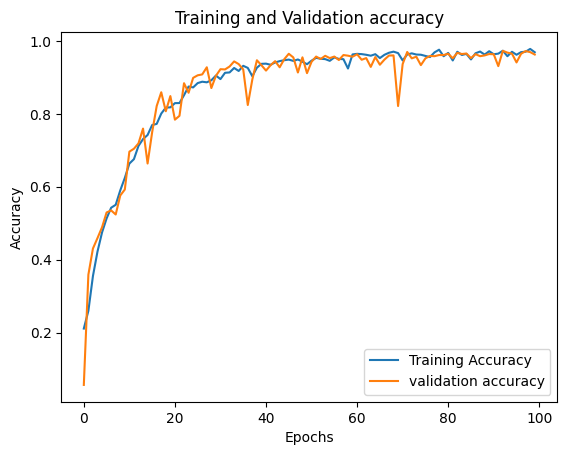

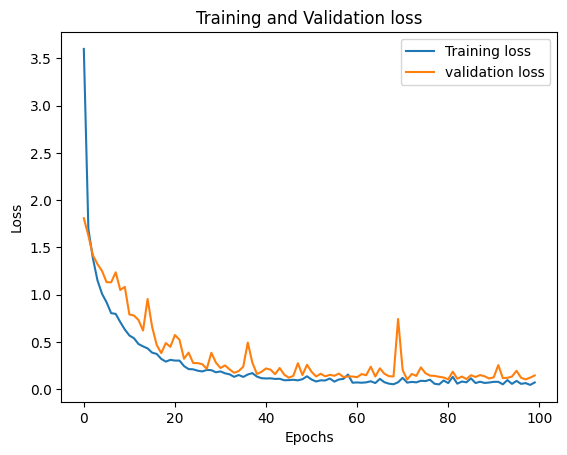

In [ ]:
plot_history(CNN_history)

### We then test the CNN model on the test data

#### Using the CNN model to predict the test set

In [ ]:
CNN_y_pred = np.argmax(CNN_model.predict(X_test_CNN), axis = -1)
CNN_y_pred

112/112 [==============================] - 23s 200ms/step


array([4, 4, 4, ..., 0, 0, 0])

#### Showing the classification report and the confusion matrix for the CNN model trained on MFCC Features on the test data.

              precision    recall  f1-score   support

           0     0.9368    0.9889    0.9622        90
           1     0.7841    0.9928    0.8762       139
           2     0.9462    0.9578    0.9520       569
           3     0.9121    0.9606    0.9358       508
           4     0.9802    0.9329    0.9559      1698
           5     0.9635    0.9736    0.9685       569

    accuracy                         0.9510      3573
   macro avg     0.9205    0.9678    0.9418      3573
weighted avg     0.9537    0.9510    0.9515      3573



<Figure size 3000x4000 with 0 Axes>

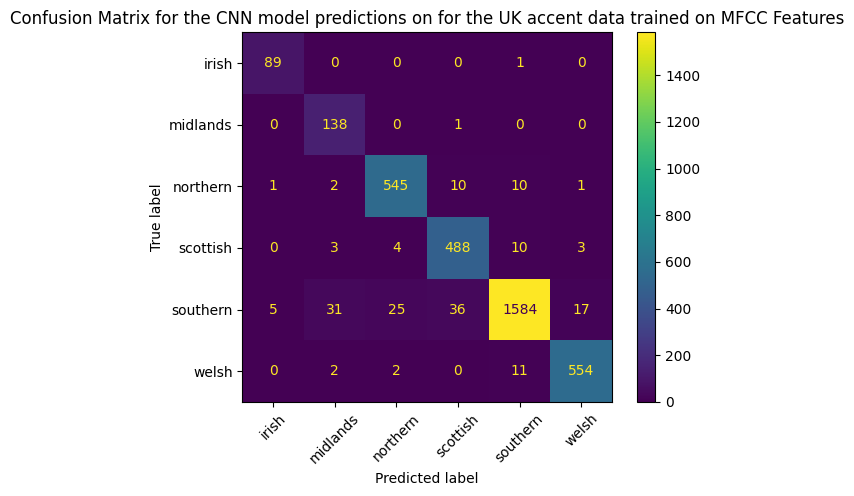

In [ ]:
display_classification_report_and_confusion_matrix(y_test, CNN_y_pred, "CNN", "MFCC Features")

#### We then proceede to test a single prediction on the CNN model
+ We decided to try it on an irish accent because irish accents are the smallest and so if the model did not handle class weights properly, it should struggle to make predictions on the irish class

In [ ]:
CNN_single_pred_test = MFCC_model_single_prediction("/content/drive/MyDrive/Accent Detection/UK English Accents/irish/irm_02484_00059735647.wav",CNN_model, "CNN")

1/1 [==============================] - 0s 45ms/step


First we play the audio of the accent that we are trying to predict

In [ ]:
CNN_single_pred_test["play_audio"]

Then we show the prediction of what the model thinks the accent is

In [ ]:
CNN_single_pred_test["Prediction"]

'irish'

Finally we take a look at how confident the model is about its prediction. In this case, the model is 100% sure that the accent is an Irish one

In [ ]:
CNN_single_pred_test["confidence_levels"]

,class,Confidence level
0,irish,100.0
1,midlands,0.0
2,northern,0.0
3,scottish,0.0
4,southern,0.0
5,welsh,0.0


+ The CNN model predicts this accent correctly

<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />

### LSTM model

#### Building the architecture for the LSTM

+ We experimented with different architectures and the one below proved to be the most effective. It was found out that adding the kernel regularizers proved to be the game changer for this model.
+ The model often struggled with overfitting with out convergernce and so to make the model as optimal as possible we used kernel regulatizer to reduce the overfitting and stopped the model just before it began to overfit

In [ ]:
from keras.src.layers.core.masking import Masking
tf.keras.backend.clear_session()
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape = (X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(256, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.LSTM(128, kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),

    # Dense layer
    tf.keras.layers.Dense(64, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(6, activation = "softmax")
])

#### Compiling the LSTM model
+ For compiling the LSTM model, we experimented with different loss functions learning rates and optimizers including Stochastic gradient descent (SGD), but a learning rate of 0.000001 with the Adaptive Moment Estimation (ADAM) proved to give the best results and a categoricalCrossentropy loss function with a label smoothing of 0.1

In [ ]:
LSTM_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001),
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics = ["accuracy"]
              )

LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 868, 40)           0         
                                                                 
 lstm (LSTM)                 (None, 868, 256)          304128    
                                                                 
 dropout (Dropout)           (None, 868, 256)          0         
                                                                 
 batch_normalization (Batch  (None, 868, 256)          1024      
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

#### We also found that adding a learning rate schedular callback to reduce the learning rate from 0.0001 to 0.000001 helped to reduce but not entirely reduce overfitting

In [ ]:
def lr_schedule(epoch):
  if epoch < 11:
    return 0.0001  # starting learining rate


  else:
    return 0.000001

# Create the LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

#### We then trained the CNN model for 3000 epochs with a batch size of 512, the learning rate scheduler mentioned above and balanced class weights we defined earlier. We used this set of parameters because they proved to be the most optimal after a series of testing

In [ ]:
tf.keras.backend.clear_session()
with tf.device('/GPU:0'):
  LSTM_history = LSTM_model.fit(X_train, tf.keras.utils.to_categorical(y_train),
                      validation_data = (X_val, tf.keras.utils.to_categorical(y_val)),
                      epochs = 3000,
                      batch_size = 512,
                      class_weight = class_weights,
                      callbacks=[lr_callback])

In [ ]:
# save_to_pickle(pickle_prepared_model_path, "LSTM", [model, history])

#### Reading the LSTM model from its pickle object

In [ ]:
LSTM_model, LSTM_history = read_pickle(f"{drive_path}/Pickle Objects/", "RNN.pkl")

### We then test the LSTM model on the test data

#### Using the LSTM model to predict the test set

In [ ]:
LSTM_y_pred = np.argmax(LSTM_model.predict(X_test), axis = -1)
LSTM_y_pred

112/112 [==============================] - 39s 322ms/step


array([4, 4, 4, ..., 0, 0, 0])

#### Showing the classification report and the confusion matrix for the LSTM model trained on MFCC Features on the test data.

              precision    recall  f1-score   support

           0     0.8738    1.0000    0.9326        90
           1     0.7318    0.9424    0.8239       139
           2     0.7113    0.8401    0.7703       569
           3     0.5576    0.9055    0.6902       508
           4     0.9637    0.7044    0.8139      1698
           5     0.9222    0.8963    0.9091       569

    accuracy                         0.8018      3573
   macro avg     0.7934    0.8814    0.8233      3573
weighted avg     0.8479    0.8018    0.8079      3573



<Figure size 3000x4000 with 0 Axes>

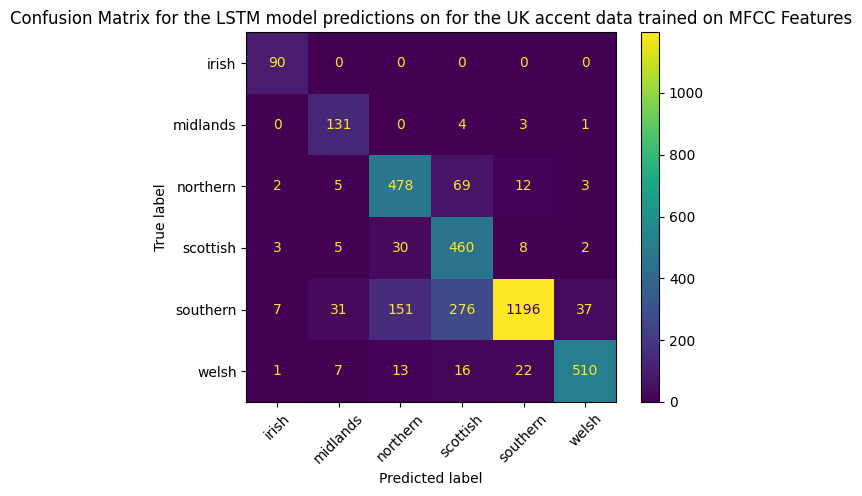

In [ ]:
display_classification_report_and_confusion_matrix(y_test, LSTM_y_pred, "LSTM", "MFCC Features")

#### We then proceede to test a single prediction on the LSTM model
+ For the CNN model, We decided to predict on an irish accent because irish accents are the smallest and so if the model did not handle class weights properly, it should struggle to make predictions on the irish class. This time we attempt on a midlands accent because midland accents are the second smallest class just to see



In [ ]:
LSTM_single_pred_test = MFCC_model_single_prediction(f"{drive_path}/UK English Accents/midlands/mif_02484_00235587550.wav",LSTM_model, "LSTM")

1/1 [==============================] - 0s 180ms/step


First we play the audio of the accent that we are trying to predict



In [ ]:
LSTM_single_pred_test["play_audio"]

Then we show the prediction of what the model thinks the accent is



In [ ]:
LSTM_single_pred_test["Prediction"]

'midlands'

Finally we take a look at how confident the model is about its prediction. In this case, the model is 100% sure that the accent is a midlands one

In [ ]:
LSTM_single_pred_test["confidence_levels"]

,class,Confidence level
0,irish,0.0
1,midlands,100.0
2,northern,0.0
3,scottish,0.0
4,southern,0.0
5,welsh,0.0


<br />
<br />
<br />
<br />
<br />
<br />
<br />
<br />

### Multilayer Perceptron (MLP) model


#### Building the architecture for the MLP Model
+ We experimented with different architectures, but the MLP was difficult to train to a good accuracy. The set of parameters below proved to be the best for training it although it still performed poorly



In [ ]:
tf.keras.backend.clear_session()
MLP_model = tf.keras.Sequential([
    #input layer
    tf.keras.layers.Flatten(input_shape = (X_train.shape[1], X_train.shape[2])),

    # 1st hidden layer
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dropout(0.2),

    # 2nd hidden layer
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.Dropout(0.2),

    # 4th hidden layer
    tf.keras.layers.Dense(64, activation = "relu"),

    # # 5th hidden layer
    # tf.keras.layers.Dense(32, activation = "relu"),
    # tf.keras.layers.Dropout(0.2),

    # # 6th hidden layer
    # tf.keras.layers.Dense(16, activation = "relu"),
    # tf.keras.layers.Dropout(0.2),

    # Output layer
    tf.keras.layers.Dense(6, activation = "softmax")
])

#### Compiling the MLP model
+ For compiling the MLP model,we found that a learning rate of 0.0001 with the Adaptive Moment Estimation (ADAM) optimizer  proved to give the best results for this model. We also noticed that using a sparse_categorical_crossentropy loss fuction performed slightly better than the categorical cross entopy for this model



In [ ]:
MLP_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"]
              )

MLP_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 34720)             0         
                                                                 
 dense (Dense)               (None, 512)               17777152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 6)                 3

#### We also found that using the learning rate scheduler defined below proved to be the best adjustments for training this model

In [ ]:
def lr_schedule(epoch):
  if epoch < 11:
    return 0.0001  # Initial learning rate

  elif epoch < 100:
    return 1e-6  # Lower learning rate for later epochs

  elif epoch < 200:
    return 1e-7

  elif epoch < 180:
    return 1e-6

  elif epoch < 190:
    return 1e-7


  else:
    return 1e-7

# Create the LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

#### We then trained the CNN model for 100 epochs with a batch size of 64 and balanced class weights we defined earlier. We used this set of parameters because they proved to be optimal after a series of testing



In [ ]:
tf.keras.backend.clear_session()
with tf.device('/GPU:0'):
  history = MLP_model.fit(X_train, y_train,
                      validation_data = (X_val, y_val),
                      epochs = 3000,
                      batch_size = 64,
                      class_weight = class_weights,
                      callbacks=[lr_callback]
  )

Streaming output truncated to the last 5000 lines.
358/358 [==============================] - 4s 11ms/step - loss: 0.7884 - accuracy: 0.5305 - val_loss: 1.1297 - val_accuracy: 0.5260 - lr: 1.0000e-07
Epoch 502/3000
358/358 [==============================] - 4s 11ms/step - loss: 0.7886 - accuracy: 0.5320 - val_loss: 1.1293 - val_accuracy: 0.5252 - lr: 1.0000e-07
Epoch 503/3000
358/358 [==============================] - 4s 11ms/step - loss: 0.7856 - accuracy: 0.5325 - val_loss: 1.1285 - val_accuracy: 0.5259 - lr: 1.0000e-07
Epoch 504/3000
358/358 [==============================] - 4s 11ms/step - loss: 0.7822 - accuracy: 0.5328 - val_loss: 1.1282 - val_accuracy: 0.5262 - lr: 1.0000e-07
Epoch 505/3000
358/358 [==============================] - 4s 11ms/step - loss: 0.7933 - accuracy: 0.5305 - val_loss: 1.1286 - val_accuracy: 0.5255 - lr: 1.0000e-07
Epoch 506/3000
358/358 [==============================] - 4s 11ms/step - loss: 0.7840 - accuracy: 0.5319 - val_loss: 1.1281 - val_accuracy: 0.52

#### Saving the MLP model as a pickle object using the save_pickle function we created



In [ ]:
#save_to_pickle(pickle_prepared_model_path, "MLP", [model, history])

#### Reading the MLP model from the pickle object using the read_pickle function we created



In [ ]:
MLP_model, MLP_history = read_pickle(f"/content/drive/MyDrive/Accent Detection/Pickle Objects/", "MLP.pkl")

#### Plotting the history of the MLP model



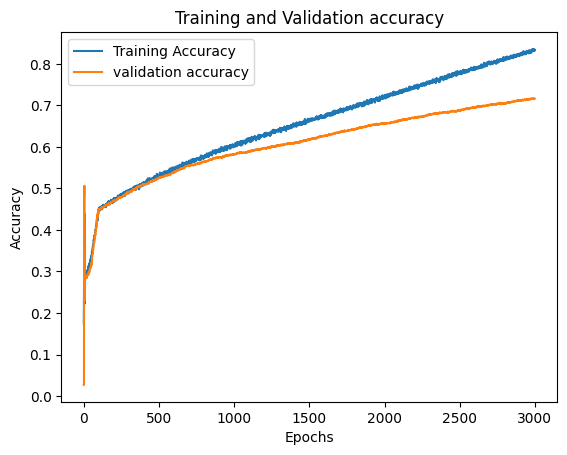

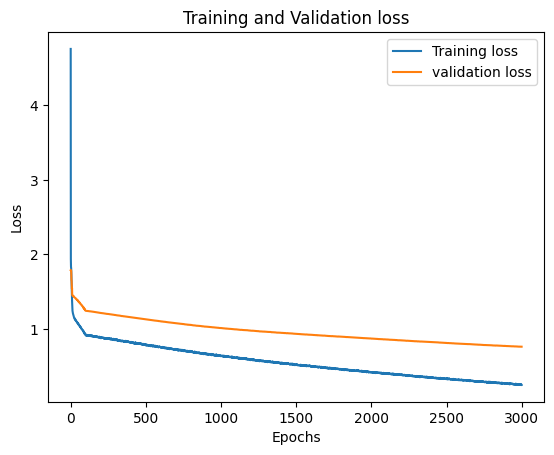

In [ ]:
plot_history(MLP_history)

+ This model clearly overfits and does not train well so there is no way we can propose it
+ This is the behaviour we were able to get for the MLP on this data and so we use this only for comaparison sake

### We then test the MLP model on the test data
#### Using the MLP model to predict the test set



In [ ]:
MLP_y_pred = np.argmax(MLP_model.predict(X_test), axis = -1)
MLP_y_pred

112/112 [==============================] - 2s 14ms/step


array([4, 4, 4, ..., 0, 0, 0])

#### Showing the classification report and the confusion matrix for the MLP model trained on MFCC Features on the test data.



              precision    recall  f1-score   support

           0     0.7890    0.9556    0.8643        90
           1     0.7059    0.6906    0.6982       139
           2     0.5974    0.6415    0.6186       569
           3     0.5057    0.5256    0.5154       508
           4     0.7783    0.7008    0.7375      1698
           5     0.7409    0.8594    0.7958       569

    accuracy                         0.6977      3573
   macro avg     0.6862    0.7289    0.7050      3573
weighted avg     0.7022    0.6977    0.6980      3573



<Figure size 3000x4000 with 0 Axes>

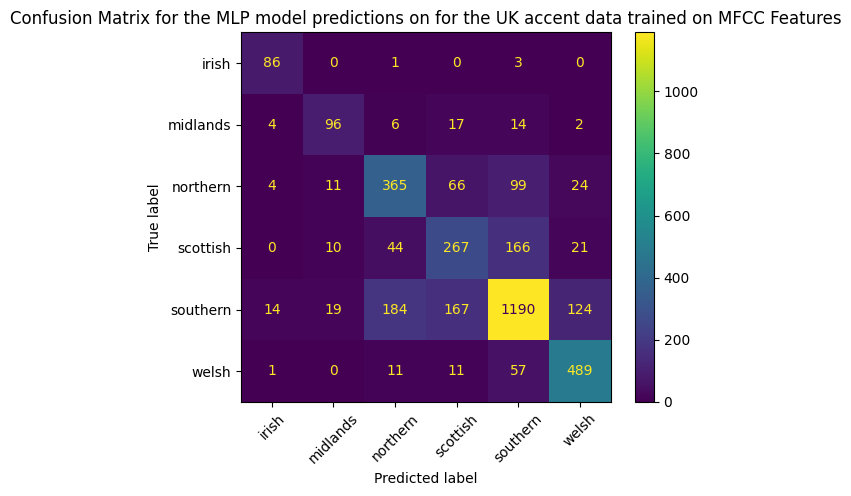

In [ ]:
display_classification_report_and_confusion_matrix(y_test, MLP_y_pred, "MLP", "MFCC Features")

#### We then proceede to test a single prediction on the MLP model
+ This time we decided to try and predict a northern accent



In [ ]:
MLP_single_pred_test = MFCC_model_single_prediction(f"{drive_path}/UK English Accents/northern/nof_02484_00119802689.wav",LSTM_model, "MLP")

1/1 [==============================] - 0s 221ms/step


First we play the audio of the accent that we are trying to predict



Then we show the prediction of what the model thinks the accent is



In [ ]:
MLP_single_pred_test["Prediction"]

'northern'

Finally we take a look at how confident the model is about its prediction. In this case, the model is 98.78% sure the accent is northern, 0.76% southern, 0.44% scottish and 0.001% welsh

In [ ]:
MLP_single_pred_test["confidence_levels"]

,class,Confidence level
0,irish,0.00
1,midlands,0.00
2,northern,98.78
3,scottish,0.44
4,southern,0.76
5,welsh,0.01


### CNN model
#### Building the architecture for the CNN Model
+ We experimented with different architectures and the one below proved to be the most effective. See the report for the most notable architectures that were used

#### Compiling the CNN model
+ For compiling the CNN model, we experimented with different learninf rates and optimizers including Stochastic gradient descent (SGD), but a learning rate of 0.0005 with the Adaptove Moment Estimation (ADAM) proved to give the best results

#### We then trained the CNN model for 100 epochs with a batch size of 64 and balanced class weights we defined earlier. We used this set of parameters because they proved to be optimal after a series of testing

#### Saving the CNN model as a pickle object using the save_pickle function we created

#### Reading the CNN model from the pickle object using the read_pickle function we created

#### Plotting the history of the CNN model

### We then test the CNN model on the test data
#### Using the CNN model to predict the test set

#### Showing the classification report and the confusion matrix for the CNN model trained on MFCC Features on the test data.

#### We then proceede to test a single prediction on the CNN model
+ We decided to try it on an irish accent because irish accents are the smallest and so if the model did not handle class weights properly, it should struggle to make predictions on the irish class

First we play the audio of the accent that we are trying to predict

Then we show the prediction of what the model thinks the accent is

Finally we take a look at how confident the model is about its prediction. In this case, the model is 100% sure that the accent is an Irish one

# Other datasets
+ Because the CNN model is the overall best performing model, we try it out on other datasets to see if it will still maintain its high accuracy.


## LibriTTS-British Accent Dataset

#### First we create the path to the LibriTTS-British Accent Dataset

In [ ]:
LibriTTS_path = f"{drive_path}/LibriTTS-British-Accents Dataset"

Creating an instance of the extract_mfcc_features, for the LibriTTs accent data



In [ ]:
extract_LibriTTS_MFCC = extract_mfcc_features()

#### Using the extract_for_multiple_classes method of the class to extract the MFCC features from the dataset

In [ ]:
LibriTTS_df = extract_LibriTTS_MFCC.extract_for_multiple_classes(LibriTTS_path, df=True)
LibriTTS_df

Extracting mfcc features for welsh class


100%|██████████| 162/162 [00:19<00:00,  8.16it/s]


Extracting mfcc features for irish class


100%|██████████| 215/215 [00:21<00:00, 10.20it/s]


Extracting mfcc features for english class


100%|██████████| 14907/14907 [20:21<00:00, 12.21it/s]


Extracting mfcc features for scottish class


100%|██████████| 204/204 [00:15<00:00, 13.28it/s]


,class names,mfccs,duration
0,welsh,"[[-366.14276, 61.332855, 24.279152, 15.034172,...",15.620000
1,welsh,"[[-370.41647, 72.96997, 23.716465, 15.030867, ...",7.700000
2,welsh,"[[-403.44916, 54.044716, 15.174387, 16.379156,...",15.200000
3,welsh,"[[-384.63156, 61.20919, 30.01779, 25.312666, 9...",8.140000
4,welsh,"[[-353.56555, 63.25689, 17.43465, 19.994839, 1...",12.930023
...,...,...,...
15483,scottish,"[[-428.987, 59.973114, 24.720432, 12.733074, 1...",8.440000
15484,scottish,"[[-448.26556, 55.402527, 11.271595, 18.111782,...",2.250023
15485,scottish,"[[-376.28214, 84.178986, 19.07669, 24.57793, 9...",0.390023
15486,scottish,"[[-393.2988, 55.036594, 17.708134, 30.192642, ...",8.280000


#### Saving the extracted LibriTTS MFCC features as a pickle object using the save_to_pickle function we created

In [ ]:
pickle_mfcc_dfs_path = f"{drive_path}/Pickle Objects/mfcc dataframes"
save_to_pickle(pickle_mfcc_dfs_path, "LibriTTS_df", LibriTTS_df)

#### Reading the LibriTTS MFCC features from the pickle object in the location where it was saved using the read pickle method we created

In [ ]:
LibriTTS_df = read_pickle(f"{drive_path}/Pickle Objects/mfcc dataframes", "LibriTTS_df.pkl")
LibriTTS_df

,class names,mfccs,duration
0,welsh,"[[-366.14276, 61.332855, 24.279152, 15.034172,...",15.620000
1,welsh,"[[-370.41647, 72.96997, 23.716465, 15.030867, ...",7.700000
2,welsh,"[[-403.44916, 54.044716, 15.174387, 16.379156,...",15.200000
3,welsh,"[[-384.63156, 61.20919, 30.01779, 25.312666, 9...",8.140000
4,welsh,"[[-353.56555, 63.25689, 17.43465, 19.994839, 1...",12.930023
...,...,...,...
15483,scottish,"[[-428.987, 59.973114, 24.720432, 12.733074, 1...",8.440000
15484,scottish,"[[-448.26556, 55.402527, 11.271595, 18.111782,...",2.250023
15485,scottish,"[[-376.28214, 84.178986, 19.07669, 24.57793, 9...",0.390023
15486,scottish,"[[-393.2988, 55.036594, 17.708134, 30.192642, ...",8.280000


In [ ]:
LibriTTS_df["class names"].value_counts()

english     14907
irish         215
scottish      204
welsh         162
Name: class names, dtype: int64

In [ ]:
LibriTTS_df = LibriTTS_df[LibriTTS_df["class names"] != "english"]
LibriTTS_df["class names"].value_counts()

irish       215
scottish    204
welsh       162
Name: class names, dtype: int64

#### Creating a function to label encode the LibriTTS MFCC features

In [ ]:
def label_LibriTTS_accents(accent):
  label = None
  if accent == "irish":
    label = 0
  elif accent == "scottish":
    label = 1
  elif accent == "welsh":
    label = 2
  return label

#### Applying the label_LibriTTS_accents function to the LibriTTS dataframe

In [ ]:
LibriTTS_df["labels"] = LibriTTS_df["class names"].apply(label_LibriTTS_accents)
LibriTTS_df

,class names,mfccs,duration,labels
0,welsh,"[[-366.14276, 61.332855, 24.279152, 15.034172,...",15.620000,2
1,welsh,"[[-370.41647, 72.96997, 23.716465, 15.030867, ...",7.700000,2
2,welsh,"[[-403.44916, 54.044716, 15.174387, 16.379156,...",15.200000,2
3,welsh,"[[-384.63156, 61.20919, 30.01779, 25.312666, 9...",8.140000,2
4,welsh,"[[-353.56555, 63.25689, 17.43465, 19.994839, 1...",12.930023,2
...,...,...,...,...
15483,scottish,"[[-428.987, 59.973114, 24.720432, 12.733074, 1...",8.440000,1
15484,scottish,"[[-448.26556, 55.402527, 11.271595, 18.111782,...",2.250023,1
15485,scottish,"[[-376.28214, 84.178986, 19.07669, 24.57793, 9...",0.390023,1
15486,scottish,"[[-393.2988, 55.036594, 17.708134, 30.192642, ...",8.280000,1


#### Splitting the LibriTTS data into X and y and into the train, validate and test data

In [ ]:
LibriTTS_X = LibriTTS_df["mfccs"]
LibriTTS_y = np.array(LibriTTS_df["labels"])

LibriTTS_X_train, LibriTTS_X_test, LibriTTS_y_train, LibriTTS_y_test = train_test_split(LibriTTS_X, LibriTTS_y, test_size = 0.2, stratify = LibriTTS_y, random_state = 42)
LibriTTS_X_train, LibriTTS_X_val, LibriTTS_y_train, LibriTTS_y_val = train_test_split(LibriTTS_X_train, LibriTTS_y_train, test_size = 0.2, stratify = LibriTTS_y_train, random_state = 42)

#### Padding the MFCC coefficient lengths that are not up to the maximumn with zeros

In [ ]:
LibriTTS_X_train = tf.keras.preprocessing.sequence.pad_sequences(LibriTTS_X_train, maxlen=868, padding='post', truncating='post', dtype='float32')
LibriTTS_X_val = tf.keras.preprocessing.sequence.pad_sequences(LibriTTS_X_val, maxlen=868, padding='post', truncating='post', dtype='float32')
LibriTTS_X_test = tf.keras.preprocessing.sequence.pad_sequences(LibriTTS_X_test, maxlen=868, padding='post', truncating='post', dtype='float32')

#### Saving the LibriTTS split data as pickle objects

In [ ]:
pickle_prepared_data_path  = f"{drive_path}/Pickle Objects/prepared data"
save_to_pickle(pickle_prepared_data_path, "prepared_LibriTTS_data", {
    "train": (LibriTTS_X_train, LibriTTS_y_train),
    "val": (LibriTTS_X_val, LibriTTS_y_val),
    "test": (LibriTTS_X_test, LibriTTS_y_test)})

#### Reading in the LibriTTS data from pickle objects

In [ ]:
LibriTTS_data = read_pickle(f"{drive_path}/Pickle Objects/prepared data/", "prepared_LibriTTS_data.pkl")

#### Assigning the LibriTTS data to thier respective variable names

In [ ]:
LibriTTS_X_train = LibriTTS_data["train"][0]
LibriTTS_X_val = LibriTTS_data["val"][0]
LibriTTS_X_test = LibriTTS_data["test"][0]

LibriTTS_y_train = LibriTTS_data["train"][1]
LibriTTS_y_val = LibriTTS_data["val"][1]
LibriTTS_y_test = LibriTTS_data["test"][1]

#### Because our proposed model is a CNN, we reshape the data to be 3-dimensional

In [ ]:
LibriTTS_X_train = LibriTTS_X_train.reshape(LibriTTS_X_train.shape[0], LibriTTS_X_train.shape[1], LibriTTS_X_train.shape[2], 1)
LibriTTS_X_val = LibriTTS_X_val.reshape(LibriTTS_X_val.shape[0], LibriTTS_X_train.shape[1], LibriTTS_X_train.shape[2], 1)
LibriTTS_X_test = LibriTTS_X_test.reshape(LibriTTS_X_test.shape[0], LibriTTS_X_train.shape[1], LibriTTS_X_train.shape[2], 1)

#### We also have to compute the class weights for the LibriTTS data as it is not balanced also

In [ ]:
# Getting the class weights for each of the classes in the dataset
LibriTTS_class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(LibriTTS_y_train),
                                        y = LibriTTS_y_train
                                    )
LibriTTS_class_weights = dict(zip(np.unique(LibriTTS_y_train), LibriTTS_class_weights))
LibriTTS_class_weights

{0: 0.8961352657004831, 1: 0.9512820512820512, 2: 1.2006472491909386}

#### Now we read in our proposed model

In [ ]:
proposed_model, _ = read_pickle(f"{drive_path}/Pickle Objects/", "CNN.pkl")

### We now carry out a series of steps to use our pretrained proposed model on the LibriTTS dataset
+ First we have to remove the last layer in our propsed model because it was built to predict 6 classes but the LibriTTS dataset expects 3. This is one of the reasons why we cant just directly test the model on the dataset without fine-tuning
+ Secondly, we create a new softmax layer designed to predict 3 classes and join it to our proposed model
+ Thirdly, we compile this new model using the same parameters as before

In [ ]:
# Assuming MLP_model is your existing model

# Removing the final softmax layer from our proposed model because the model is built for 6 classes but we want predict a dataset with just 4 classes
proposed_model_layers = proposed_model.layers[:-1]

# Adding a new softmax layer to predict between 3 classes
LibriTTS_output_layer = Dense(3, activation="softmax", name="LibriTTS_output_layer")

# Connecting the new layer to the previous proposed model output layer
LibriTTS_new_output = LibriTTS_output_layer(proposed_model_layers[-1].output)

# Creating a new model with these new parameters
LibriTTS_CNN_model = Model(inputs=proposed_model.input, outputs=LibriTTS_new_output)

# Compile the new version of our proposed model for the LibriTTS dataset  with the ADAM optimizer, CategoricalCrossentropy loss  and accuracy
LibriTTS_CNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005),
              loss = ["categorical_crossentropy"],
              metrics = ["accuracy"]
              )
# Printing the summary of our proposed model designed to finetune to the LibriTTs dataset
LibriTTS_CNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 868, 40, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 868, 40, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 434, 20, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 434, 20, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 217, 10, 64)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 217, 10, 64)       0     

#### Finetune the our proposed model on the new LibriTTS dataset

In [ ]:
tf.keras.backend.clear_session()
with tf.device('/GPU:0'):
  LibriTTS_CNN_history = LibriTTS_CNN_model.fit(
      LibriTTS_X_train, keras.utils.to_categorical(LibriTTS_y_train), batch_size = 64,
      epochs = 1000, verbose = 1,
      validation_data = (LibriTTS_X_val, keras.utils.to_categorical(LibriTTS_y_val)),
      class_weight = LibriTTS_class_weights
  )

Epoch 1/1000
6/6 [==============================] - 2s 80ms/step - loss: 11.5098 - accuracy: 0.3693 - val_loss: 4.3730 - val_accuracy: 0.3978
Epoch 2/1000
6/6 [==============================] - 0s 42ms/step - loss: 12.5012 - accuracy: 0.3827 - val_loss: 4.2441 - val_accuracy: 0.3978
Epoch 3/1000
6/6 [==============================] - 0s 41ms/step - loss: 10.8426 - accuracy: 0.3639 - val_loss: 4.1176 - val_accuracy: 0.3978
Epoch 4/1000
6/6 [==============================] - 0s 42ms/step - loss: 13.0053 - accuracy: 0.3288 - val_loss: 4.0007 - val_accuracy: 0.3978
Epoch 5/1000
6/6 [==============================] - 0s 42ms/step - loss: 10.8229 - accuracy: 0.3396 - val_loss: 3.8864 - val_accuracy: 0.3871
Epoch 6/1000
6/6 [==============================] - 0s 42ms/step - loss: 10.2177 - accuracy: 0.4016 - val_loss: 3.7722 - val_accuracy: 0.3978
Epoch 7/1000
6/6 [==============================] - 0s 42ms/step - loss: 11.5471 - accuracy: 0.3558 - val_loss: 3.6645 - val_accuracy: 0.3978
Epoch 

#### Saving the CNN fintuned on the LibriTTS data to a pickle object

In [ ]:
save_to_pickle(f"{drive_path}/Pickle Objects/", "LibriTTS_CNN_model", [LibriTTS_CNN_model, LibriTTS_CNN_history])

#### Reading the CNN finetuned on the LibriTTS from the pickle object where it is stored

In [ ]:
LibriTTS_CNN_model, LibriTTS_CNN_history = read_pickle(f"{drive_path}/Pickle Objects/", "LibriTTS_CNN_model.pkl")

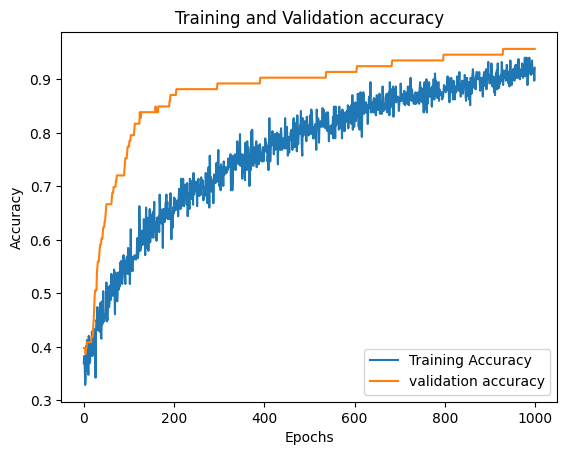

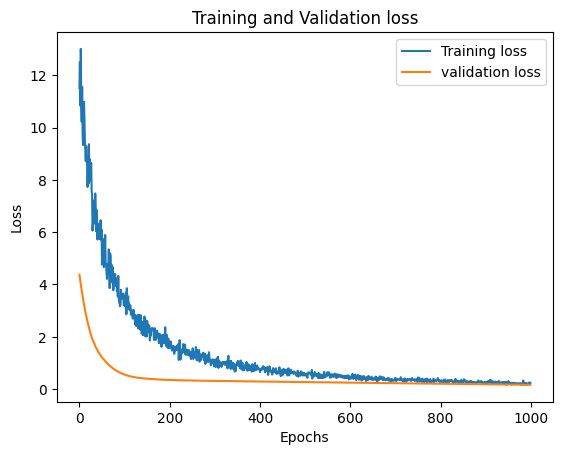

In [ ]:
plot_history(LibriTTS_CNN_history)

#### Making predictions on the test data

In [ ]:
LibriTTS_y_pred = np.argmax(LibriTTS_CNN_model.predict(LibriTTS_X_test), axis = -1)
LibriTTS_y_pred

19/19 [==============================] - 7s 7ms/step


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Displaying the confusion Matrix and classification report of the model

              precision    recall  f1-score   support

           0     0.9670    0.9535    0.9602       215
           1     0.9645    0.9314    0.9476       204
           2     0.9419    1.0000    0.9701       162

    accuracy                         0.9587       581
   macro avg     0.9578    0.9616    0.9593       581
weighted avg     0.9591    0.9587    0.9585       581



<Figure size 3000x4000 with 0 Axes>

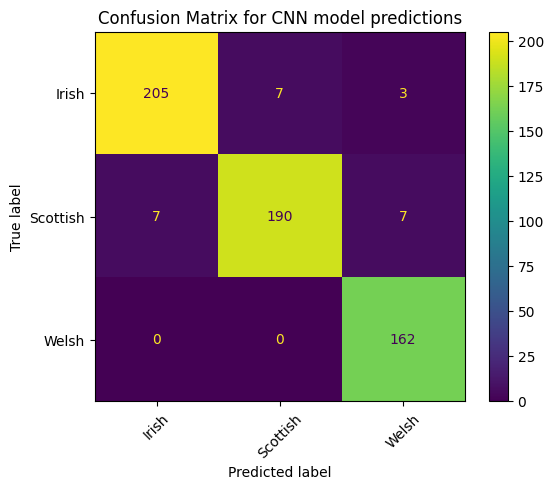

In [ ]:
display_classification_report_and_confusion_matrix(LibriTTS_y_test, LibriTTS_y_pred, "CNN", "", class_names = ["Irish", "Scottish", "Welsh"])